In [3]:
!pip install wandb

In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m013 (ma23m013-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

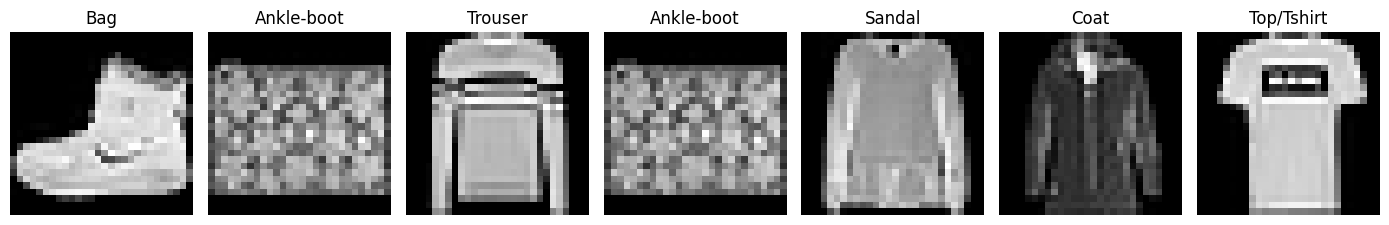

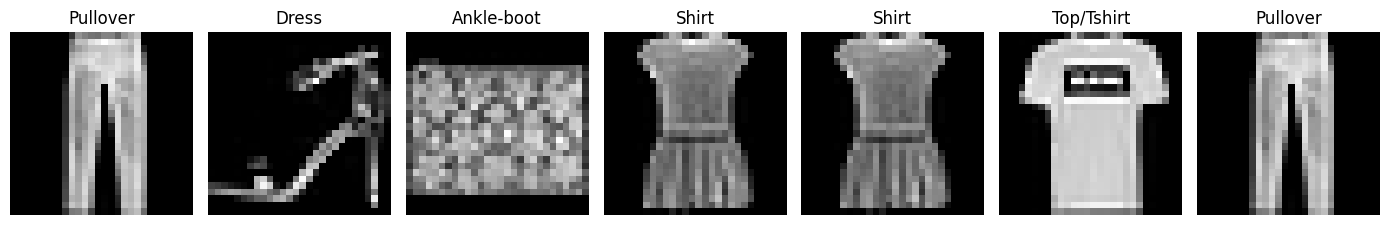

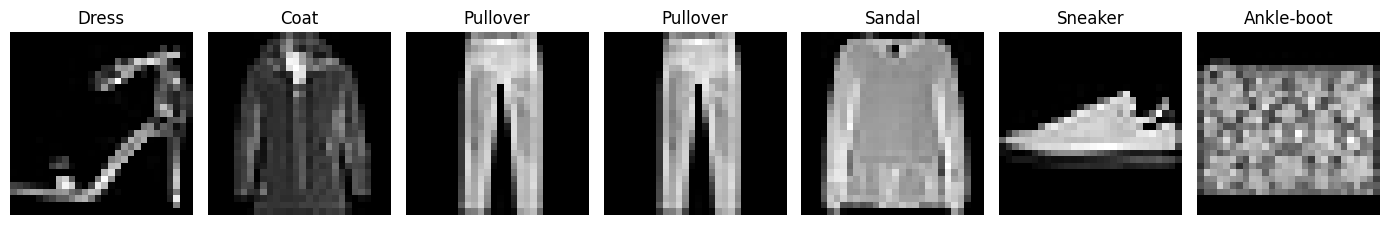

In [14]:
# Initialize WandB project
wandb.init(project='DA6401_Assignment-1')

# Load Fashion-MNIST dataset (train and test sets)
(train_img, train_lbl), (test_img, test_lbl) = fashion_mnist.load_data()

# Define class names for labels
class_names = ['Top/Tshirt', 'Pullover', 'Trouser', 'Shirt', 'Coat', 'Dress', 'Sandal', 'Sneaker', 'Ankle-boot', 'Bag']

# Select one sample image for each class
samples = {}
for i in range(36):  # Loop through first 36 images
  lbl = train_lbl[i]  # Get label of current image
  if lbl not in samples:  # If label is not already added, add it
    samples[lbl] = train_img[i]
  if len(samples) == 10:  # Stop when all 10 classes have at least one image
    break

# Convert dictionary to lists for easy indexing
sample_lbl = list(samples.keys())
sample_img = list(samples.values())

# Function to plot 7 random sample images
def plot_sample(step, index):
  fig, axes = plt.subplots(1, 7, figsize=(14, 5))  # Create figure with 7 subplots
  chosen_indices = np.random.choice(len(sample_img), 7, replace=True)  # Randomly select 7 images

  for ax, idx in zip(axes.flatten(), chosen_indices):
    ax.imshow(sample_img[idx], cmap='gray')  # Display image
    ax.set_title(class_names[sample_lbl[idx]])  # Set title with class name
    ax.axis('off')  # Remove axis for cleaner view

  plt.tight_layout()
  plt.show()
  return fig

# Log images to WandB for visualization
wandb.log({"Examples": [wandb.Image(plot_sample(0, 0), caption="Step 0"),
    wandb.Image(plot_sample(1, 0), caption="Step 1"), wandb.Image(plot_sample(2, 0), caption="Step 2")]})

# Finish WandB run
wandb.finish()
